In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
import math
import random
import cv2
import skimage.io
import glob
import os
import functools
from albumentations import *
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys

sys.path.append('../')

from config import Config
from util import DataManager
from optimizer import get_optimizer
from generator import get_dataset


tf.config.set_visible_devices([], 'GPU')

Path to images:  ../../../input/prostate-cancer-grade-assessment/train_images/
Image tiff-format:  False


### Visualization of current data generator

x shape = (5, 1536, 1536, 3)


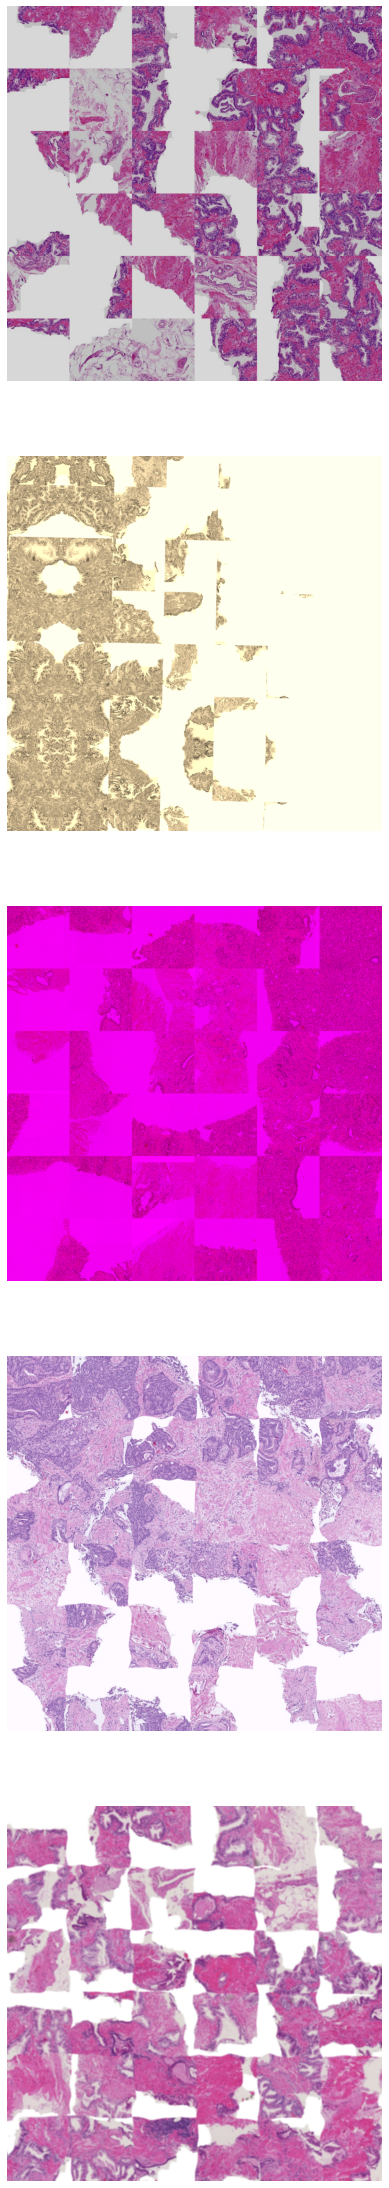

In [4]:
augmentor_heavy = (
    Compose([
        OneOf([
            ShiftScaleRotate(
                shift_limit=0.2,
                scale_limit=0.2,
                rotate_limit=90,
                p=0.3),
            ElasticTransform(
                alpha=601,
                sigma=20,
                alpha_affine=10,
                p=0.3),
            GridDistortion(
                num_steps=5,
                distort_limit=0.3,
                p=0.15),
            OpticalDistortion(
                distort_limit=0.2, 
                shift_limit=0.2,
                p=0.15),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RandomSizedCrop(
                min_max_height=(1024, 1536),
                height=1536,
                width=1536,
                w2h_ratio=0.85,
                p=0.4),
            CoarseDropout(
                max_holes=8, 
                max_height=64, 
                max_width=64,
                fill_value=169,
                p=0.2),
            Downscale(
                scale_min=0.25, 
                scale_max=0.25,
                p=0.2),
            RandomGridShuffle(
                grid=(3, 3),
                p=0.2),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            MedianBlur(
                blur_limit=7,
                p=0.1),
            GaussianBlur(
                blur_limit=7,
                p=0.1),
            Blur(
                blur_limit=7,
                p=0.1),     
            GlassBlur(
                sigma=0.7, 
                max_delta=4, 
                iterations=2,
                p=0.1),
            RandomFog(
                p=0.1),
            Posterize(
                num_bits=4,
                p=0.1),
            NoOp(
                p=0.5),
        ]),
        OneOf([
            GaussNoise(
                var_limit=(10.0, 100.0),
                p=0.2),
            ISONoise(
                color_shift=(0.05, 0.1), 
                intensity=(0.1, 0.5),
                p=0.2),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RGBShift(
                r_shift_limit=10,
                g_shift_limit=10,
                b_shift_limit=10,
                p=0.25),
            HueSaturationValue(
                hue_shift_limit=10,
                sat_shift_limit=20,
                val_shift_limit=15,
                p=0.25),
            FancyPCA(
                alpha=0.5,
                p=0.1),
            ChannelDropout(
                channel_drop_range=(1, 1),
                p=0.1),
            ToGray(
                p=0.1),
            ToSepia(
                p=0.1),
            NoOp(
                p=0.5)
        ]),
        OneOf([
            RandomBrightnessContrast(
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.3),
            RandomGamma(
                gamma_limit=(80, 120),
                p=0.3),
            NoOp(
                p=0.5)
        ]),
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)


augmentor_light = (
    Compose([
        RandomRotate90(
            p=0.5),
        Flip(
            p=0.5),
        Transpose(
            p=0.5),
    ])
)

def read_image(image_path, label):
    image = tf.io.read_file(image_path + '.jpeg')
    if tf.strings.length(image) > 6_500_000:
        # Only 3 images in train set is too big to decode without ratio = 2
        # None of the images in test set is too big to decode
        image = tf.image.decode_jpeg(image, channels=3, ratio=2)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
    return image, label
    
def _augment_image(mode):
    def transform(*features, mode=mode):
        '''Using albumentations augmentations, which will be 
        wrapped in tf.py_function, is very convenient. However, 
        for better performance, consider using TF operations 
        instead to augment the image data
        '''
        features = list(features)
        if mode == 'heavy':
            features[0] = augmentor_heavy(image=features[0].numpy())['image']
        else:
            features[0] = augmentor_light(image=features[0].numpy())['image']
        return features
    return transform

@tf.function
def compute_patches(image, label, ps=Config.input.patch_size, ss=Config.input.sample_size):
    """Computes patches to be used as input to the Neural Network.
    If number of patches exceeds the sample_size (ss), the
    patches with most information are selected"""
    image_shape = tf.shape(image)
    h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)
    pad_h = (ps - h % ps)
    pad_w = (ps - w % ps)

    pu = tf.random.uniform(shape=(), minval=0, maxval=pad_h, dtype=tf.int32)
    pd = pad_h - pu
    pl = tf.random.uniform(shape=(), minval=0, maxval=pad_w, dtype=tf.int32)
    pr = pad_w - pl

    image = tf.pad(
        image, ((pu, pd), (pl, pr), (0, 0)), constant_values=255)

    image_shape = tf.shape(image)
    h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)

    image = tf.reshape(image, (h//ps, ps, w//ps, ps, 3))
    image = tf.transpose(image, (0, 2, 1, 3, 4))
    image = tf.reshape(image, (-1, ps, ps, 3))

    num_images = tf.gather(tf.shape(image), 0)

    info = tf.reduce_sum(tf.cast(tf.reshape(image, (num_images, -1)), tf.int32), 1)

    if tf.gather(tf.shape(info), 0) < ss:

        image = tf.pad(
            image, ((0, ss-num_images), (0, 0), (0, 0), (0, 0)), constant_values=255)

        paddings = tf.zeros(ss-num_images, dtype=tf.int32)+(ps**2*3*255)
        info = tf.concat((info, paddings), axis=0)

    indices = tf.gather(tf.argsort(info), tf.range(ss))
    image = tf.gather(image, indices)
    return image, label

@tf.function
def augment_image(patch, label, p=0.5):
    """Performs random rotation, random flip (u/d, l/r),
    and random transpose, based on probability p"""
    r1 = tf.random.uniform(
        shape=(4,), minval=0, maxval=1)
    r2 = tf.random.uniform(
        shape=(), minval=0, maxval=4, dtype=tf.int32)
    if r1[0] > (1-p):
        patch = tf.image.rot90(patch, k=r2)
    if r1[1] > (1-p):
        patch = tf.image.random_flip_left_right(patch)
    if r1[2] > (1-p):
        patch = tf.image.random_flip_up_down(patch)
    if r1[3] > (1-p):
        patch = tf.transpose(patch, (1, 0, 2))
    return patch, label

@tf.function
def stitch_patches(patches, label, ps=Config.input.patch_size, l=int(np.sqrt(Config.input.sample_size))):
    """Stitches together patches into one single
    big image, with augmentation on patch-level"""
    image = tf.zeros([0, ps, ps, 3], dtype=tf.uint8)
    #patches = tf.random.shuffle(patches) # TESTING
    for i in range(len(patches)):
        patch, _ = augment_image(tf.gather(patches, i), None)
        image = tf.concat((
            image, tf.expand_dims(patch, 0)
        ), axis=0)
    image = tf.reshape(image, (-1, ps*l, ps, 3))
    image = tf.transpose(image, (0, 2, 1, 3))
    image = tf.reshape(image, (ps*l, ps*l, 3))
    return image, label


def get_dataset(dataframe,
                input_path,
                batch_size,
                training,
                augment,
                tta=1,
                input_size=(1536, 1536, 3),
                objective='bce',
                buffer_size=1,
                cache=False):


    def nested_stiching(x, y):
        return (
            tf.data.Dataset.from_tensor_slices((x, y))
            .map(stitch_patches, tf.data.experimental.AUTOTUNE)
            .map(augment_image, tf.data.experimental.AUTOTUNE)
            .batch(tta)
        )

    if cache:
        if not(os.path.isdir('../tmp/')):
            os.mkdir('../tmp')
        else:
            files = glob.glob(f'../tmp/*')
            for f in files:
                os.remove(f)
        if training:
            cache_path = '../tmp/cache_train'
        else:
            cache_path = '../tmp/cache_infer'

    image_paths = (input_path + dataframe.image_id).values.astype(str)

    if objective == 'mse':
        labels = dataframe.isup_grade.values.astype(np.int32)
        labels = np.expand_dims(labels, 1)
    elif objective == 'bce':
        labels = np.zeros((len(dataframe), 5), dtype=np.int32)
        for i, label in enumerate(dataframe.isup_grade):
            labels[i, :label] = 1
    elif objective == 'cce':
        labels = dataframe.isup_grade.values
        labels = np.eye(6)[labels].astype(np.int32)
    else:
        raise ValueError("objective has to be either 'mse', 'bce' or 'cce'")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(read_image, tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(compute_patches, tf.data.experimental.AUTOTUNE)

    if cache:
        dataset = dataset.cache(cache_path)

    if tta > 1:
        dataset = dataset.map(
            lambda x, y: (
                tf.tile(tf.expand_dims(x, 0), (tta, 1, 1, 1, 1)),
                tf.tile(tf.expand_dims(y, 0), (tta, 1))),
            tf.data.experimental.AUTOTUNE)
        dataset = dataset.flat_map(nested_stiching)
        dataset = dataset.batch(batch_size)
        dataset = dataset.map(
            lambda x, y: (
                tf.reshape(x, (-1, *input_size)),
                tf.reshape(y, (-1, labels.shape[1]))),
            tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.map(stitch_patches, tf.data.experimental.AUTOTUNE)
        if augment:
            dataset = dataset.map(lambda x, y: tf.py_function(
                func=_augment_image('heavy'),
                inp=[x,y],
                Tout=[tf.uint8, tf.int32]), tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)

    #dataset = dataset.map(preprocess_input, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

data = DataManager.get_train_data()

dataset = get_dataset(
    dataframe=data,
    input_path=Config.input.path,
    batch_size=Config.train.batch_size,
    training=False,
    augment=True,
    tta=1,
    input_size=(1536, 1536, 3),
    objective='bce',
    buffer_size=1,
    cache=False)

for x,y in dataset.take(1):
    x = x.numpy()
    print("x shape =", x.shape)

fig, axes = plt.subplots(Config.train.batch_size, 1, figsize=(20, 40))

if Config.train.batch_size > 1:
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(x[i])
        ax.axis('off')
else:
    axes.imshow(x[0])
    axes.axis('off')

### experimental

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import skimage.io
import glob
import os
from albumentations import *

from config import Config


def run(Config):
    def map_decorator(func):
        def wrapper(*args):
            return tf.py_function(
                func=func,
                inp=[*args],
                Tout=[tf.uint8, tf.int32]
            )
        return wrapper

    augmentor = (
        Compose([
          RandomRotate90(
              p=0.5),
          Flip(
              p=0.5),
          Transpose(
              p=0.5),
       ])
    )

    @map_decorator
    def augmentation(image, label):
        image = augmentor(image=image.numpy())['image']
        return image, label

    if Config.input.tiff_format:
        def _crop_white(image):
            value = 255
            assert image.shape[2] == 3
            assert image.dtype == np.uint8
            ys, = (image.min((1, 2)) < value).nonzero()
            xs, = (image.min(0).min(1) < value).nonzero()
            if len(xs) == 0 or len(ys) == 0:
                return image
            image = image[ys.min():ys.max() + 1, xs.min():xs.max() + 1]
            del ys
            del xs
            return image

        @map_decorator
        def read_image(image_path, label, resize_ratio=Config.input.resize_ratio):
            image_path = image_path.numpy().decode('utf-8')
            image = skimage.io.MultiImage(image_path + '.tiff')
            image = image[0]
            image = _crop_white(image)
            if resize_ratio != 1:
                new_w = int(image.shape[1]*resize_ratio)
                new_h = int(image.shape[0]*resize_ratio)
                image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
            return image, label
    else:
        @map_decorator
        def read_image(image_path, label, resize_ratio=Config.input.resize_ratio):
            image_path = image_path.numpy().decode('utf-8')
            image = cv2.imread(image_path + '.jpeg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if resize_ratio != 1:
                new_w = int(image.shape[1]*resize_ratio)
                new_h = int(image.shape[0]*resize_ratio)
                image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
            return image, label

    @tf.function
    def compute_patches(image, label, ps=Config.input.patch_size, ss=Config.input.sample_size):
        """Computes patches to be used as input to the Neural Network.
        If number of patches exceeds the sample_size (ss), the
        patches with most information are selected"""
        image_shape = tf.shape(image)
        h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)
        pad_h = (ps - h % ps)
        pad_w = (ps - w % ps)

        pu = tf.random.uniform(shape=(), minval=0, maxval=pad_h, dtype=tf.int32)
        pd = pad_h - pu
        pl = tf.random.uniform(shape=(), minval=0, maxval=pad_w, dtype=tf.int32)
        pr = pad_w - pl

        image = tf.pad(
            image, ((pu, pd), (pl, pr), (0, 0)), constant_values=255)

        image_shape = tf.shape(image)
        h, w = tf.gather(image_shape, 0), tf.gather(image_shape, 1)

        image = tf.reshape(image, (h//ps, ps, w//ps, ps, 3))
        image = tf.transpose(image, (0, 2, 1, 3, 4))
        image = tf.reshape(image, (-1, ps, ps, 3))

        num_images = tf.gather(tf.shape(image), 0)

        info = tf.reduce_sum(tf.cast(tf.reshape(image, (num_images, -1)), tf.int32), 1)

        if tf.gather(tf.shape(info), 0) < ss:

            image = tf.pad(
                image, ((0, ss-num_images), (0, 0), (0, 0), (0, 0)), constant_values=255)

            paddings = tf.zeros(ss-num_images, dtype=tf.int32)+(ps**2*3*255)
            info = tf.concat((info, paddings), axis=0)

        indices = tf.gather(tf.argsort(info), tf.range(ss))
        image = tf.gather(image, indices)
        return image, label

    def _patch_augment(patch):
        """Performs random rotation, random flip (u/d, l/r),
        and random transpose, based on probability p"""
        p = 0.5
        r1 = tf.random.uniform(
            shape=(4,), minval=0, maxval=1)
        r2 = tf.random.uniform(
            shape=(), minval=0, maxval=4, dtype=tf.int32)
        if r1[0] > (1-p):
            patch = tf.image.rot90(patch, k=r2)
        if r1[1] > (1-p):
            patch = tf.image.random_flip_left_right(patch)
        if r1[2] > (1-p):
            patch = tf.image.random_flip_up_down(patch)
        if r1[3] > (1-p):
            patch = tf.transpose(patch, (1, 0, 2))
        return patch

    @tf.function
    def stitch_patches(patches, label, ps=Config.input.patch_size, l=int(np.sqrt(Config.input.sample_size))):
        """Stitches together patches into one single
        big image, with augmentation on patch-level"""
        image = tf.zeros([0, ps, ps, 3], dtype=tf.uint8)
        for i in range(len(patches)):
            _patch = _patch_augment(tf.gather(patches, i))
            image = tf.concat((
                image, tf.expand_dims(_patch, 0)
            ), axis=0)
        image = tf.reshape(image, (-1, ps*l, ps, 3))
        image = tf.transpose(image, (0, 2, 1, 3))
        image = tf.reshape(image, (ps*l, ps*l, 3))
        return image, label

    @tf.function
    def preprocess_input(x, y, mode=Config.input.preprocess_mode):
        x = tf.cast(x, dtype=tf.dtypes.float32)
        y = tf.cast(y, dtype=tf.dtypes.float32)
        if mode == 'tf':
            x /= 127.5
            x -= 1.
            return x, y
        elif mode == 'torch':
            x /= 255.
            mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
            std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
            x -= mean
            x /= std
            return x, y
        elif mode == 'caffe':
            mean = tf.constant([103.939, 116.779, 123.68], dtype=tf.float32)
            x -= mean
            return x, y
        elif mode == 'float':
            x /= 255.
            return x, y
        else:
            return x, y

    def get_dataset(dataframe, input_path, batch_size, training,
                    augment, buffer_size=1, cache=False):
        if cache:
            if not(os.path.isdir('tmp/')):
                os.mkdir('tmp')
            else:
                files = glob.glob(f'tmp/*')
                for f in files:
                    os.remove(f)
            if training:
                cache_path = 'tmp/cache_train'
            else:
                cache_path = 'tmp/cache_infer'

        image_paths = (input_path + dataframe.image_id).values.astype(str)
        labels = np.zeros((len(dataframe), 5), dtype=np.int32)
        for i, label in enumerate(dataframe.isup_grade):
            labels[i, :label] = 1.

        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        dataset = dataset.shuffle(buffer_size)
        dataset = dataset.map(read_image, tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(compute_patches, tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(stitch_patches, tf.data.experimental.AUTOTUNE)

        if cache:
            dataset = dataset.cache(cache_path)

        if augment:
            dataset = dataset.map(augmentation, tf.data.experimental.AUTOTUNE)

        dataset = dataset.map(preprocess_input, tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        return dataset
    
    return get_dataset

Input size = 1536.0
x shape = (2, 1536, 1536, 3)


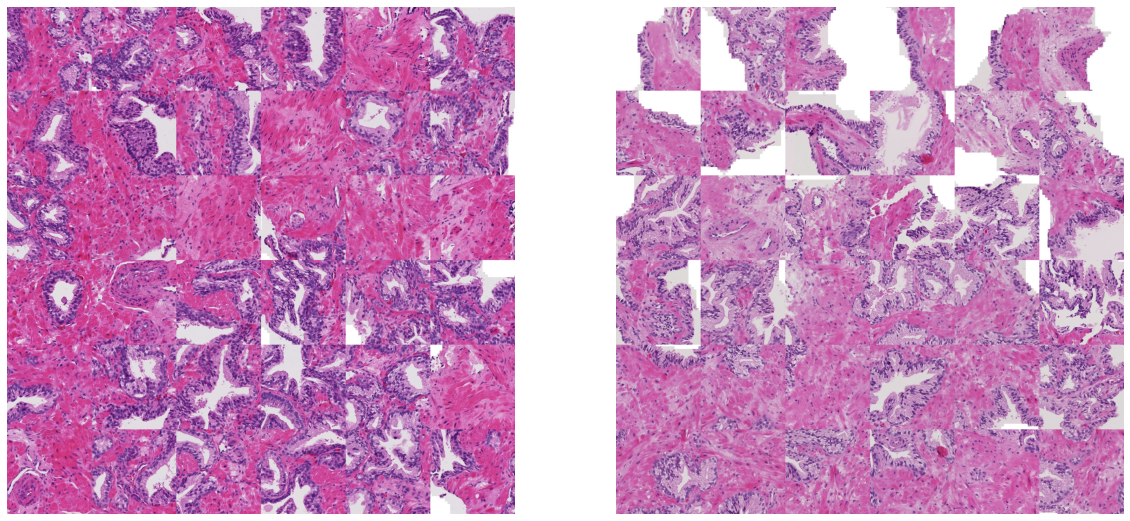

In [13]:
Config.input.path = Config.input.path[:-2] + "0/"
Config.input.patch_size = 256
Config.input.sample_size = 6*6
Config.input.preprocess_mode = 'float'

print("Input size =", Config.input.patch_size * np.sqrt(Config.input.sample_size))

get_dataset = run(Config)

dataset = get_dataset(
    dataframe=data, 
    input_path=Config.input.path,
    batch_size=Config.train.batch_size,
    training=True,
    augment=True,
    buffer_size=1,
    cache=False,
)

for x,y in dataset.take(1):
    x = x.numpy()
    print("x shape =", x.shape)

fig, axes = plt.subplots(1, Config.train.batch_size, figsize=(20, 20))

if Config.train.batch_size > 1:
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(x[i])
        ax.axis('off')
else:
    axes.imshow(x[0])
    axes.axis('off')

In [12]:
Config.input.path 

'../input/prostate-cancer-grade-assessment/train_images_jpeg_10'